# Metrics

### Base imports

In [1]:
from __future__ import print_function, division

import os
from os.path import join as pj
import shutil
from glob import glob

import numpy as np
np.random.seed = 0  # for reproducibility

import pandas as pd

import matplotlib
%matplotlib inline
from matplotlib import pylab as plt
# %config InlineBackend.figure_format = 'retina'

from matplotlib.patches import Circle
import matplotlib.patheffects as PathEffects

import seaborn as sns

from PIL import Image

import json

from tqdm import tqdm

### DL imports

In [2]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.models import Model
from keras import metrics
from keras.callbacks import ModelCheckpoint, TensorBoard

Using TensorFlow backend.


Check GPU:

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15653317880739434537
]


### Special imports

In [140]:
import cv2

### Constants

In [141]:
BASE_SIZE = 30
IMAGE_HEIGHT, IMAGE_WIDTH = 9 * BASE_SIZE, 16 * BASE_SIZE

N_CHANNELS = 3
N_CLASSES = 2

In [167]:
VAL_IMAGES_FROM_VIDEOS_DIR = './data/train/val_images_from_videos/'
SWITCH_FRAMES_PATH = './data/train/videos/ideal.txt'

In [168]:
WEIGHTS_PATH = './pretrained_weights/checkpoint-446.hdf5'

### Handy funtions

In [169]:
def list_dir_with_full_paths(dir_path):
    dir_abs_path = os.path.abspath(dir_path)
    return sorted([os.path.join(dir_abs_path, file_name) for file_name in os.listdir(dir_abs_path)])

In [170]:
def load_switch_frames(path):
    if os.path.exists(path):
        with open(path) as fin:
            video_name_to_switch_frame = dict()
            for line in fin.readlines():
                line_splitted = line.strip().split(' ')
                video_name, switch_frame = line_splitted[0], int(line_splitted[-1])

                video_name_to_switch_frame[video_name] = switch_frame
        return video_name_to_switch_frame
    else:
        return None

### Load model

In [171]:
def build_model(image_height, image_width, n_channels, n_classes, lr=0.001):
    model = Sequential()
    model.add(Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(image_height, image_width, n_channels)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])
    
    return model

In [172]:
model = build_model(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS, N_CLASSES)

In [173]:
model.load_weights(WEIGHTS_PATH)

### Preprocess image

In [174]:
def preprocess_image(image, image_height, image_width):
    image = image / 255
    image = cv2.resize(image, (image_width, image_height))
    
    return image

### Make predictions for video (dir of images)

In [184]:
def predict_for_images_dir(images_dir, model):
    images_paths = list_dir_with_full_paths(images_dir)
    
    predictions = []
    for image_path in images_paths:
        image = np.array(Image.open(image_path))
        image = preprocess_image(image, IMAGE_HEIGHT, IMAGE_WIDTH)
        predictions.append(np.squeeze(model.predict(np.expand_dims(image, axis=0))))
        
    return np.array(predictions)

### Load val images and true frame switches

In [185]:
video_name_to_switch_frame = load_switch_frames(SWITCH_FRAMES_PATH)

In [186]:
val_images_from_videos_paths = list_dir_with_full_paths(VAL_IMAGES_FROM_VIDEOS_DIR)

In [187]:
predictions = []
true_frame_switches = []

for val_images_from_videos_path in tqdm(val_images_from_videos_paths):
    true_frame_switches.append(video_name_to_switch_frame[os.path.basename(val_images_from_videos_path) + '.avi'])
    
    prediction = predict_for_images_dir(val_images_from_videos_path, model) 
    predictions.append(prediction)


100%|██████████| 20/20 [04:48<00:00, 14.61s/it]


### Visualization

In [200]:
def plot_signal(signal, true_frame_switch=None):
    plt.plot(signal)
    
    if true_frame_switch is not None and true_frame_switch != -1:
        plt.axvline(true_frame_switch, color='red')

    plt.show()

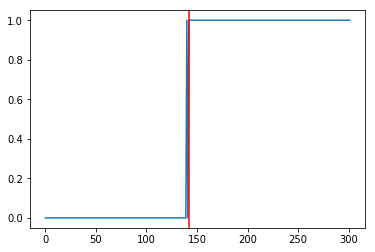

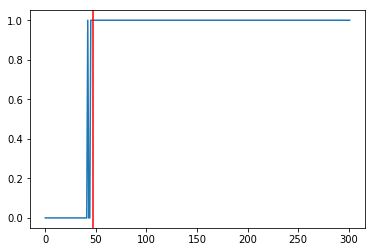

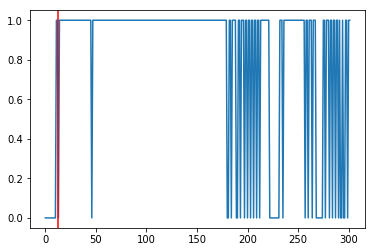

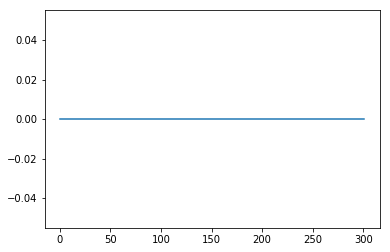

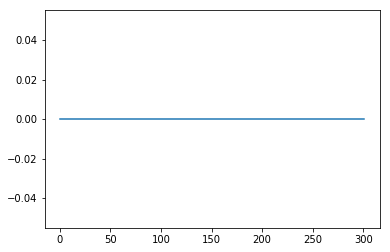

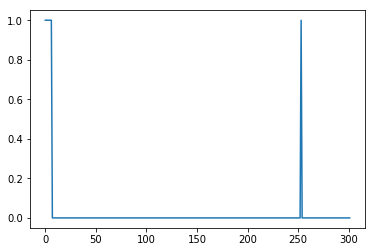

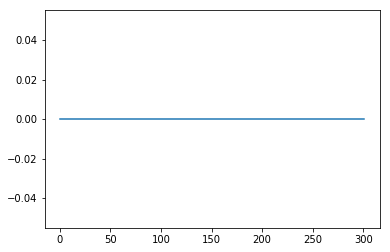

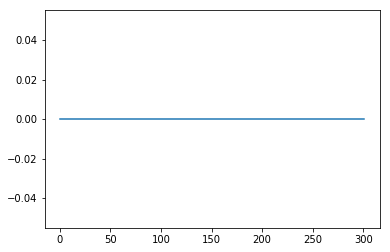

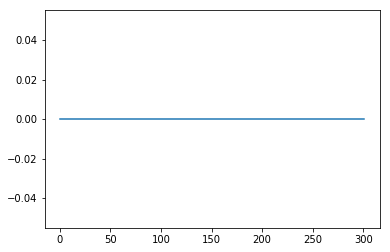

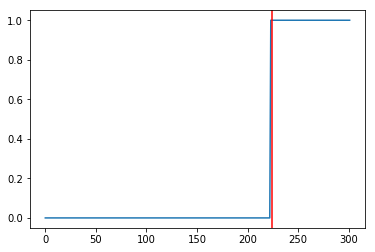

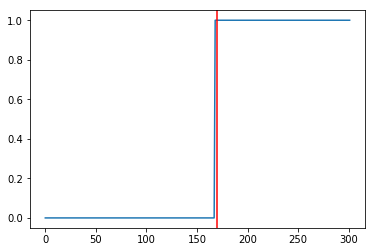

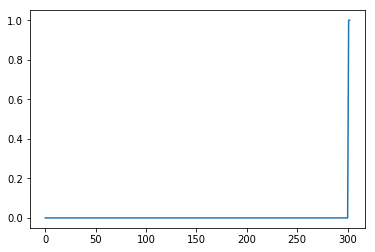

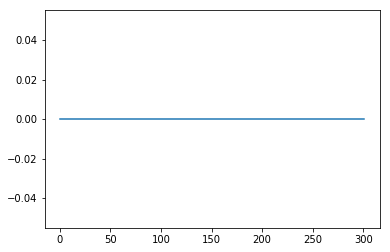

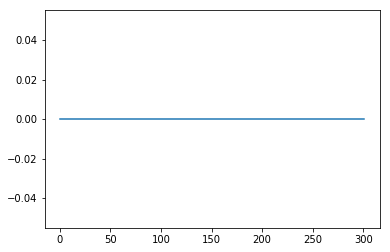

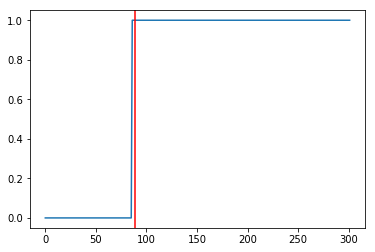

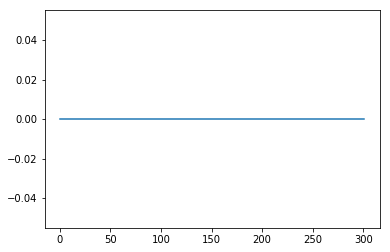

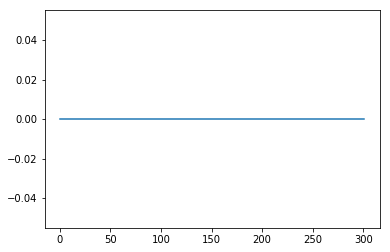

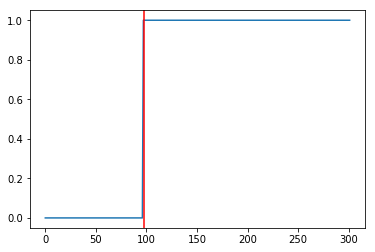

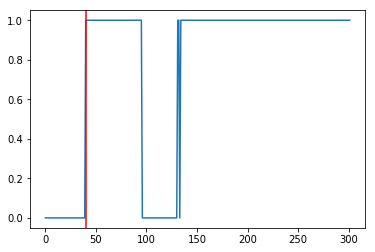

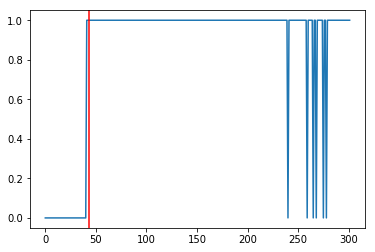

In [201]:
for prediction, true_frame_switch in zip(predictions, true_frame_switches):
    prediction_argmax = np.argmax(prediction, axis=1)
    plot_signal(prediction_argmax, true_frame_switch)